In [27]:
# import the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [5]:
#Load the Dataset

file_path = 'Online Retail.xlsx'

# Read the Excel file into a DataFrame
data = pd.read_excel(file_path)




Explore and Clean the Dataset.

In [6]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
# Check for missing values in each column
missing_values = data.isnull().sum()
print(missing_values)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [10]:
# Drop rows with missing CustomerID
data.dropna(subset=['CustomerID'], inplace=True)

In [11]:
# Remove rows with negative Quantity and Price
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

In [12]:
data['CustomerID'] = data['CustomerID'].astype(int)

# Verify the data type conversion
print(data.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int32
Country                object
dtype: object


Compute Recency, Frequency and Monetary Values.

In [13]:
snapshot_date = max(data['InvoiceDate']) + pd.DateOffset(days=1)

data['Total'] = data['Quantity'] * data['UnitPrice']
     


In [14]:
#rfm is the recency, frequency and monetary values
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Total': 'sum'
})
     

In [15]:
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Total': 'MonetaryValue'}, inplace=True)
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


Map RFM Values onto a 1-5 Scale

In [16]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


In [17]:
# Calculate custom bin edges for Recency, Frequency, and Monetary scores
recency_bins = [rfm['Recency'].min()-1, 20, 50, 150, 250, rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min() - 1, 2, 3, 10, 100, rfm['Frequency'].max()]
monetary_bins = [rfm['MonetaryValue'].min() - 3, 300, 600, 2000, 5000, rfm['MonetaryValue'].max()]

In [18]:
# Calculate Recency score based on custom bins
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=recency_bins, labels=range(1, 6), include_lowest=True)

# Reverse the Recency scores so that higher values indicate more recent purchases
rfm['R_Score'] = 5 - rfm['R_Score'].astype(int) + 1

# Calculate Frequency and Monetary scores based on custom bins
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=range(1, 6), include_lowest=True).astype(int)
rfm['M_Score'] = pd.cut(rfm['MonetaryValue'], bins=monetary_bins, labels=range(1, 6), include_lowest=True).astype(int)

In [19]:
# Print the first few rows of the RFM DataFrame to verify the scores
print(rfm[['R_Score', 'F_Score', 'M_Score']].head(10))

            R_Score  F_Score  M_Score
CustomerID                           
12346             1        1        5
12347             5        3        4
12348             3        3        3
12349             5        1        3
12350             1        1        2
12352             4        3        4
12353             2        1        1
12354             2        1        3
12355             2        1        2
12356             4        2        4


K-Means Clustering.

In [20]:
# Extract RFM scores for K-means clustering
X = rfm[['R_Score', 'F_Score', 'M_Score']]
     

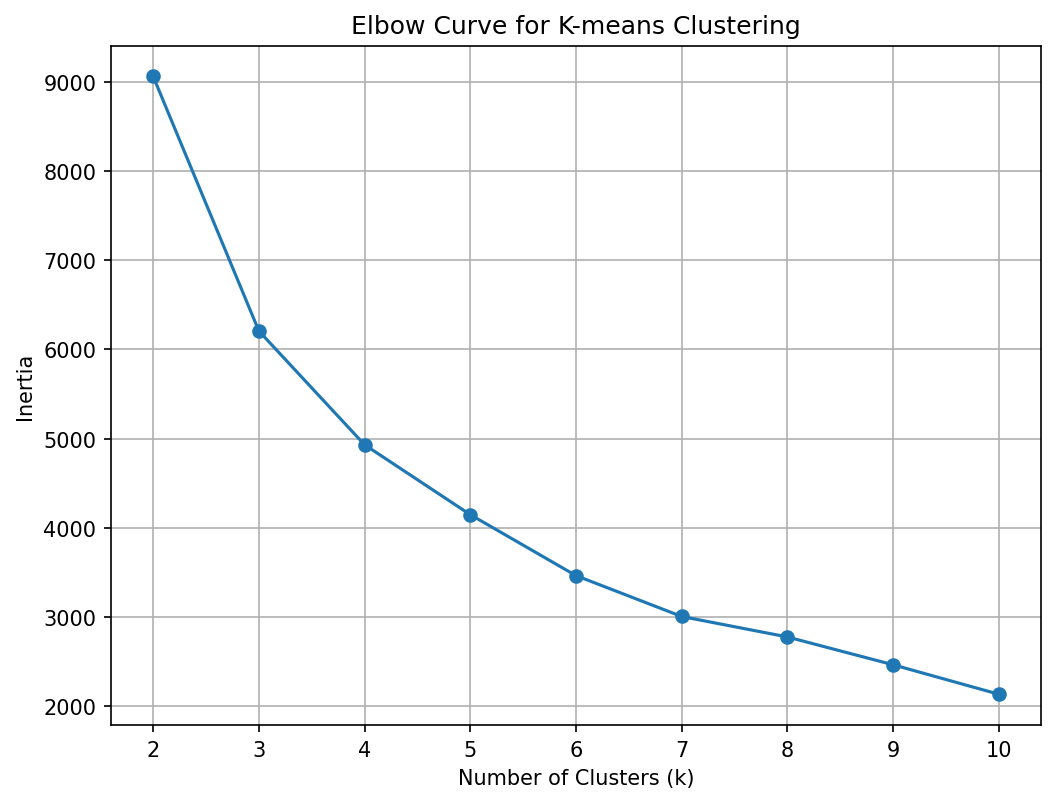

In [21]:
# Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

In [22]:
# Perform K-means clustering with best K
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)
     

Interpret the Clusters to Identify Customer Segments.

In [23]:
# Group by cluster and calculate mean values
cluster_summary = rfm.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()
     

In [24]:
print(cluster_summary)

   Cluster   R_Score   F_Score   M_Score
0        0  3.886957  1.077470  1.702767
1        1  4.684377  3.189532  3.754956
2        2  1.487368  1.055789  1.642105
3        3  3.029002  2.090487  3.156613


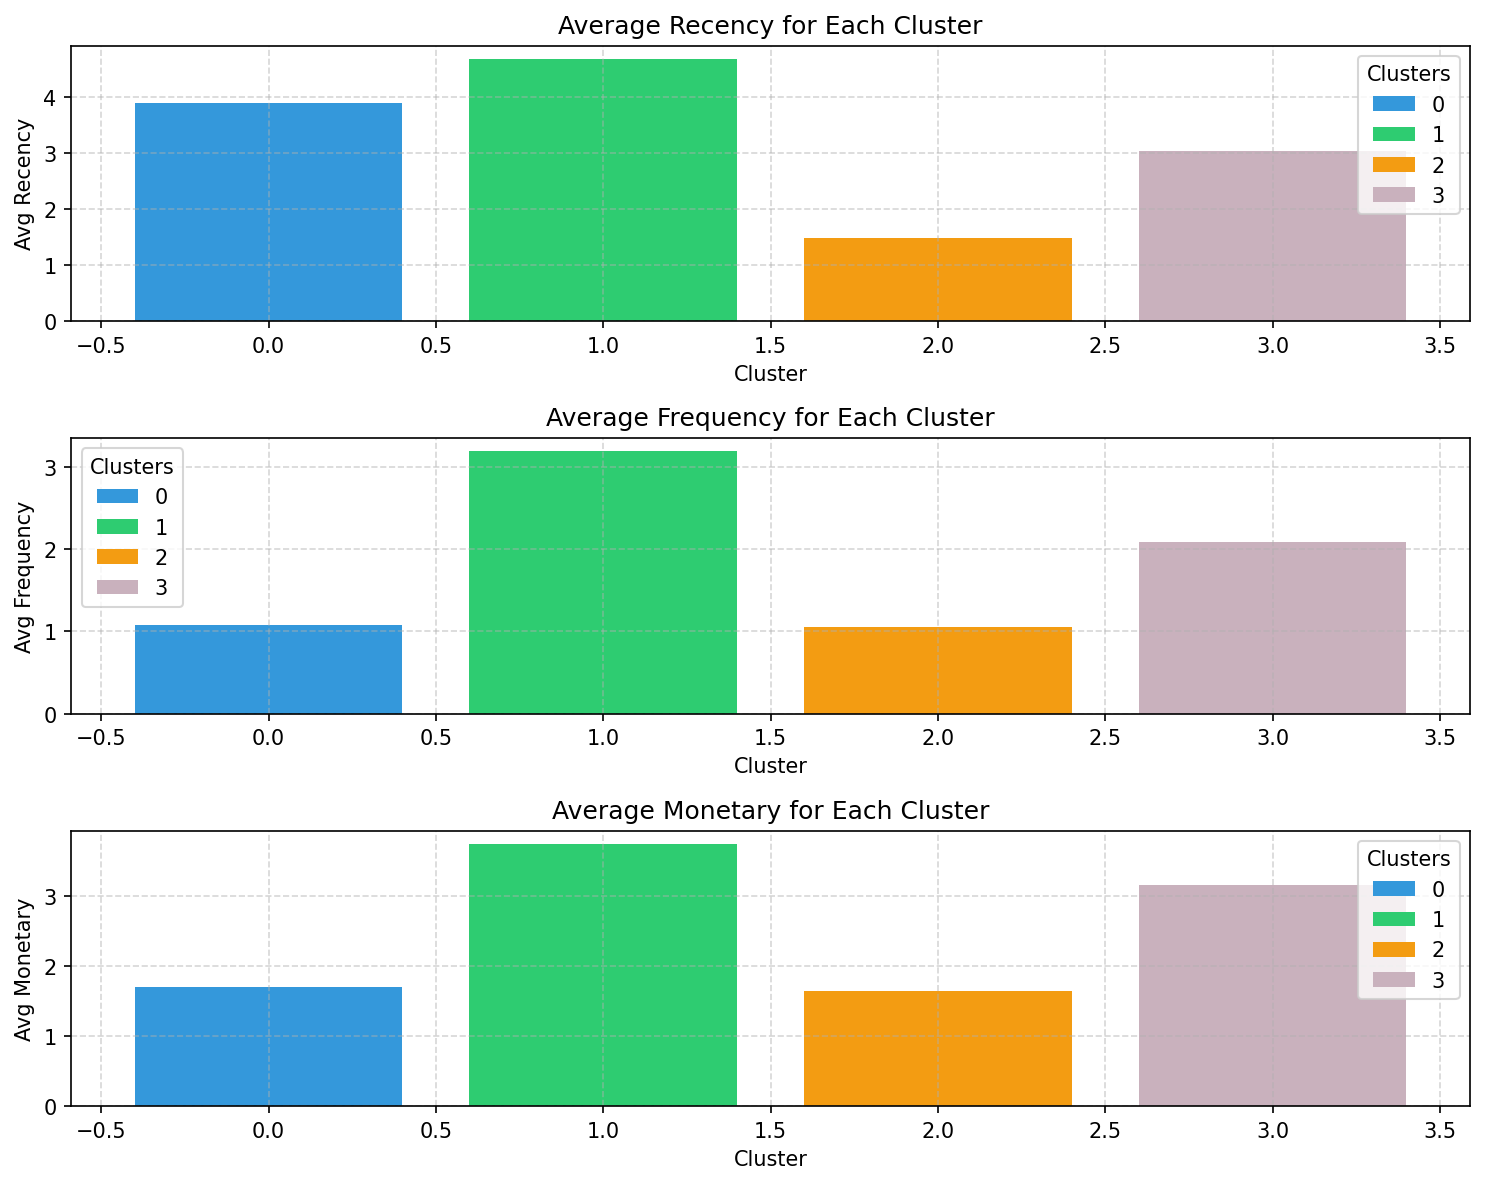

In [25]:
colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']

# Plot the average RFM scores for each cluster
plt.figure(figsize=(10, 8),dpi=150)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary['R_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary['F_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary['M_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()
     


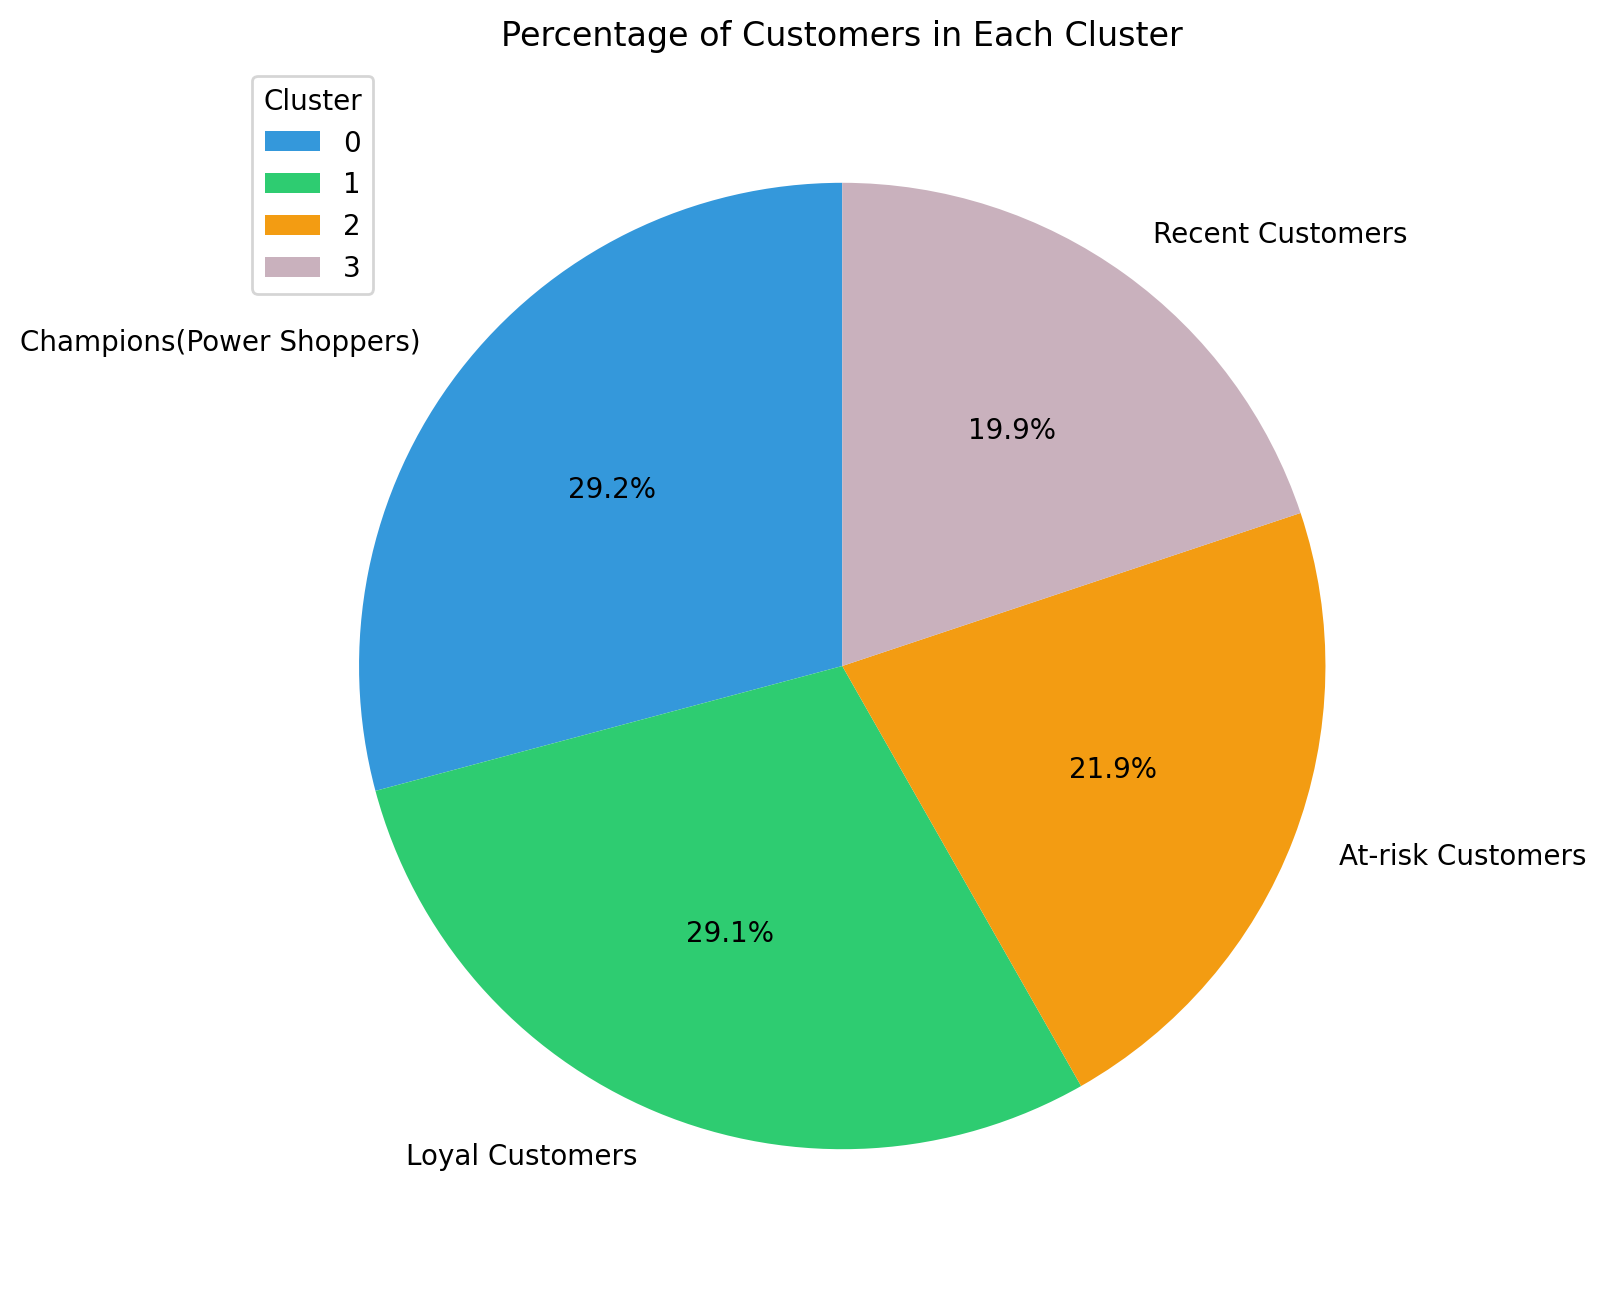

In [26]:
cluster_counts = rfm['Cluster'].value_counts()

colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
# Calculate the total number of customers
total_customers = cluster_counts.sum()

# Calculate the percentage of customers in each cluster
percentage_customers = (cluster_counts / total_customers) * 100

labels = ['Champions(Power Shoppers)','Loyal Customers','At-risk Customers','Recent Customers']

# Create a pie chart
plt.figure(figsize=(8, 8),dpi=200)
plt.pie(percentage_customers, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Customers in Each Cluster')
plt.legend(cluster_summary['Cluster'], title='Cluster', loc='upper left')

plt.show()
     